# Ising GNN

## Imports

In [1]:
%cd /Users/rodrigo/Post-Grad/Ising_GNN

/Users/rodrigo/Post-Grad/Ising_GNN


In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time
from utils import import_data, compute_KNN_graph, create_batch,reconstruct_symmetric_matrix, read_motion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:


def create_graph(X_train, X_test, y_train, y_test, size=190 ,method={'knn' : 10}):
    
    train_data = []
    val_data = []

    # Creating train data in pyG DATA structure
    for i in range((X_train.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_train.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
        
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A

        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])

        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']


        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)
        
        train_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                               y=torch.tensor((y_train.iloc[i]))))

          
    # Creating test data in pyG DATA structure
    for i in range((X_test.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_test.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
                
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A   
        
        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])
            
        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']
          
        
        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)

        val_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                             y=torch.tensor((y_test.iloc[i]))))

    return train_data,val_data

## 2D Ising model simulation by MCMC

### $$E = -J\sum_{ij}^{N} \sigma_i \sigma_j; \quad P(\sigma_i flip | \Delta E > 0)= e^{-\beta \Delta E}; \quad P(\sigma_i flip | \Delta E < 0) = 1$$ $$; \quad \beta = \frac{1}{kT}$$

In [5]:
# Random initial state
def initial_state(L,string):
    if string == "aligned":
            state = np.full((L,L), 1,dtype=float)
    elif string == "random":
        state = 2 * np.random.randint(2, size=(L,L)) - 1
    else:
        return print("write aligned or random")
    return state

In [6]:
# Total energy calculation
@jit(nopython=True,fastmath=True,nogil=True)
def Total_Energy(config, J):
    L = len(config)
    total_energy = 0
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (J*total_energy/4) # we need to take of the repeated spins that we counted

In [7]:
# Monte Carlo algorithm 
@jit(nopython=True,fastmath=True,nogil=True)
def MC_met(config,beta,J):
    L = len(config)
    a = np.random.randint(0, L)
    b = np.random.randint(0, L)
    sigma =  config[a, b]
    neighbors = config[(a+1)%L, b] + config[a, (b+1)%L] + config[(a-1)%L, b] + config[a, (b-1)%L]
    del_E = 2*sigma*neighbors
    if del_E < 0:
        sigma *= -1
    elif np.random.rand() < np.exp(-del_E*beta):
        sigma *= -1
    config[a, b] = sigma
    return config

In [8]:
# Order Parameter
@jit(nopython=True,fastmath=True,parallel=True)
def mag(config):
    return np.sum(config)

In [9]:
@jit(nopython=True,fastmath=True,nogil=True)
def temporalseries(T,config,iterations,iterations_fluc,fluctuations,J,n):

    temporal_series = np.zeros((fluctuations,n,n))
    mag_data = np.zeros(fluctuations)
    ene_data = np.zeros(fluctuations)
    beta = 1/T
    
    #thermal equilibrium
    for i in range(iterations):
        #if i % 1000000 == 0:
            #print(i/iterations)
        config = MC_met(config,beta, J)
        
    for z in range(fluctuations):
        
        for i in range(iterations_fluc):
            config = MC_met(config,beta,J)

        temporal_series[z] = config
        ene_data[z] = Total_Energy(config, J) 
        mag_data[z] = mag(config)  
        
    return temporal_series, ene_data, mag_data

In [10]:
# Matrix containing all the system states
#@jit(nopython=True,fastmath=True,nogil=True)
def Matrix_X(Temps,config,iterations,J,n, block_size):
    
    fluctuations = 200

    X = np.zeros((len(Temps), int((n//block_size)**4)))#,int(((n)//block_size*block_size)**2)))

    for t in range(len(Temps)):
        print('Models ', t + 1, end="\r",flush=True)
        #if t%100 == 0:
            #print('Models ', t, end="\r",flush=True)
            #print('Temp ',Temps[t], end="\r",flush=True)

        model = temporalseries(Temps[t], config, iterations, n*n, fluctuations, J, n)
        avg_model = average_blocks(model, block_size)

        avg_model_df = pd.DataFrame(avg_model.reshape(fluctuations,avg_model.shape[1]*avg_model.shape[1]))
        #avg_model_df = avg_model_df#.diff(1).dropna()
        corr_matrix = (pd.DataFrame(avg_model_df).corr()).replace(1,0)#*10
        
        X[t,:] = corr_matrix.values.reshape(1,corr_matrix.shape[1]*corr_matrix.shape[1])
    

    return  X



In [11]:
def average_blocks(model, block_size):
    time_series_size = len(model[0][:,0,0]) 
    avg_model = np.zeros((time_series_size,int(len(model[0][1])/block_size),int(len(model[0][1])/block_size)))

    for t in range(time_series_size):
        for i in range(0,(len(model[0][0]) - block_size + 1),block_size):
            for j in range(0, (len(model[0][0]) - block_size + 1),block_size):
                l_0 = block_size
                avg_model[t][i//block_size, j//block_size] = np.mean(model[0][t][i:(i+l_0),j:(j+l_0)])
    return avg_model

In [12]:
@jit(nopython=True, fastmath=True, nogil=True)
def corr_net(temporal_series):
    
    steps = len(temporal_series)
    spins = len(temporal_series[0])**2
    
    temporal_series_linear = temporal_series.reshape((steps*spins ))
    
    corr_array = np.array([0.0])
    xi = np.zeros(steps)
    xj = np.zeros(steps)
    for i in range(spins):
        corr = np.zeros(spins - (i+1))
        for j in range(i+1,spins):
            for n in range(steps):
                xi[n] = temporal_series_linear[i + n*spins]
                xj[n] = temporal_series_linear[j + n*spins]

            diff_i = list()
            diff_j = list()
            for a in range(1, len(xi)):
                value_i = xi[a] - xi[a - 1]
                value_j = xj[a] - xj[a - 1]
                diff_i.append(value_i)
                diff_j.append(value_j)
            corr[j - (i+1)] = float(np.corrcoef(diff_i,diff_j)[0,1])

            #corr[j - (i+1)] = float(np.corrcoef(xi,xj)[0,1])
        corr_array = np.concatenate((corr_array,corr))
        
    return corr_array

## Experimental setup

# TESTAR SE QUALQUER MA
TRIX COM DIST NORMAL SEGUE O PADRÃO

In [21]:
250//13

19

#### fluctuations. increase iterations between time series points

In [14]:
J = 1     # J
n = 250    # Lattice size
iterations = ((n*n)*n)    # Iterations to thermal equilibrium
T_1 = np.linspace(1.6,2.21,400)
T_2 = np.linspace(2.21,2.35,800)
#T_3 = np.linspace(2.5,4,100)
Temps = np.hstack((T_1,T_2)).ravel()#,T_3 )).ravel()



In [15]:
config = initial_state(n,"random")


X = Matrix_X(Temps, config,iterations,J,n,13)

In [26]:
(19*19)**2

130321

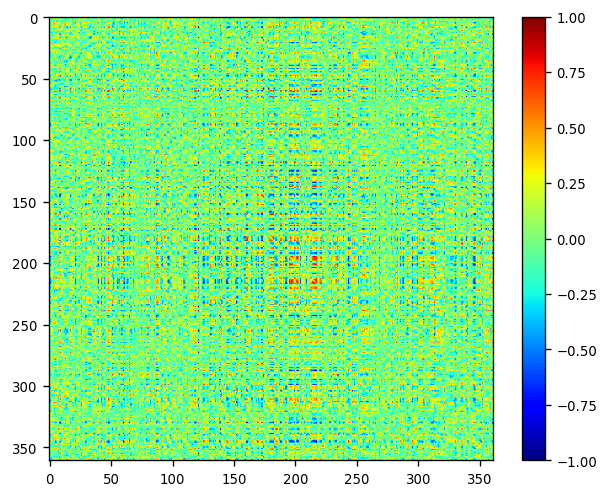

In [31]:
plt.figure(dpi=120)
plt.imshow(X[732,:].reshape(361,361), cmap='jet',vmin=-1, vmax=1)
plt.colorbar()

In [33]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=300)

# ax1.imshow(X[1,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet', vmin=-1, vmax=1)#, cmap='Greys')
# ax2.imshow(X[100,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet',vmin=-1, vmax=1)#, cmap='Greys')
# ax3.imshow(X[-1,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet',vmin=-1, vmax=1)#, cmap='Greys')

# for i in [ax1,ax2,ax3]:
#     i.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)

# plt.show()

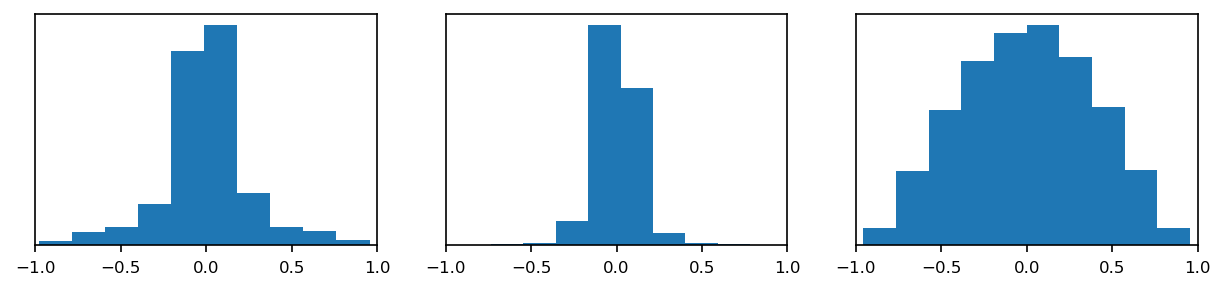

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=150,figsize=(10,2))

ax1.hist(X[0,:])#, cmap='Greys')
ax1.set_xlim(-1,1)
ax2.hist(X[4,:])#, cmap='Greys')
ax2.set_xlim(-1,1)
ax3.hist(X[-1,:])#, cmap='Greys')
ax3.set_xlim(-1,1)

for i in [ax1,ax2,ax3]:
    i.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)

plt.show()

In [35]:
def upper_triangle_array(df):
    #df = df.astype(float)
    matrix = df
    result = matrix[np.triu_indices_from(matrix,1)]
    return result.reshape(1,len(result))

In [53]:
X_aux = X.copy()

In [55]:

X_aux = X_aux[:,:].reshape(X.shape[0],int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1])))[:,14:-14,14:-14]
X_aux.shape

(1200, 333, 333)

In [56]:
X = np.zeros((X.shape[0], int((333*333 - 333)/2)))
for i in range(X.shape[0]):
    X[i,:] = upper_triangle_array(X_aux[i,:].reshape(333,333))
    
    

# X = np.zeros(( X.shape[0] , int((int(np.sqrt(X.shape[1]))*int(np.sqrt(X.shape[1])) - int(np.sqrt(X.shape[1])))/2)))
# for i in range(X.shape[0]):
#     X[i,:] = upper_triangle_array(X_aux[i,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))))

In [15]:
#X = np.loadtxt('Ising_GNN.txt').reshape(1200,17955)

In [57]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X),pd.DataFrame(Temps),test_size=0.15, shuffle=True, random_state=42)

In [58]:
A = reconstruct_symmetric_matrix(333,X_train.iloc[420,:])#.mean(axis=0))

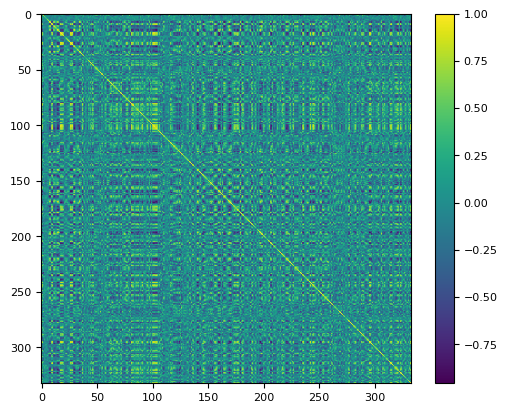

In [59]:
plt.imshow(A)
plt.colorbar()
plt.show()

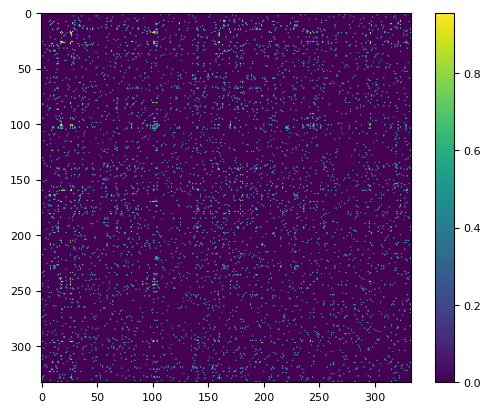

In [60]:
plt.imshow(np.array(compute_KNN_graph(A, 10)))
plt.colorbar()
plt.grid(False)
plt.show()

In [62]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test,size=333)

#train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST) #,method={'threshold': 0.2})

In [63]:
print(train_data[0])

Data(x=[333, 333], edge_index=[2, 4924], edge_attr=[4924, 1], y=[1])


In [64]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=64)


In [65]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool
from torch_geometric.nn import aggr


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.4):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(100,64)
        
        #self.gat1 = GATv2Conv(int(num_features), 148, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(148*6, 100, heads=1)
        #self.gat3 = GATv2Conv(100*2, 64, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 128, K=k_order)
        self.conv2 = ChebConv(128, 128, K=k_order)
        self.conv3 = ChebConv(128, 80, K=k_order)


        self.lin1 = torch.nn.Linear(80, 16)
        self.lin2 = torch.nn.Linear(16, 1)

        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


        
        self.pool = global_mean_pool
        
        self.aggregation = aggr.SoftmaxAggregation()

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        x = torch.nn.functional.leaky_relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr) #func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn1(x)
        x = torch.nn.functional.leaky_relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat2(x, edge_index))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn2(x)
        x = torch.nn.functional.leaky_relu(self.conv3(x, edge_index,edge_attr))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat3(x, edge_index))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn3(x)
        
        x = self.pool(x, batch)
        #x = self.aggregation(x, batch)
        x1 = self.lin1(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        x2 = self.lin2(x1)
        #x = func.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        return (x1,x2)

In [66]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[1]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)

    return mae, mse, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    loss = nn.MSELoss()
    l1_weight = 0
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)[1]
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (y.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
        
    return mae, mse, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[1]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
    return mae,mse, loss_all / len(val_data)


In [68]:
metrics = {"loss_train" : [], "loss_test" : [], "mae_test" : [], "mae_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(333, 2, 3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=.1, verbose=True)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
   
 #model.apply(init_weights)

min_v_loss = np.inf  

NUM_EPOCHS = 240

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_mae, train_mse, train_loss = GCN_train(train_loader,loop)
    test_mae, test_mse, test_loss = GCN_test(val_loader)
    TRAIN_mae, TRAIN_mse, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    #scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['mae_test'].append(test_mae)
    metrics['mae_train'].append(TRAIN_mae)
    
    print('Val MAE {} , Val Loss {}'.format(test_mae, test_loss))
    print('Train MAE {} , Train Loss {}'.format(TRAIN_mae, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/240]: 100%|█████████████████| 16/16 [00:19<00:00,  1.22s/it, loss=2.96]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 1.437406676161103 , Val Loss 2.0982950210571287
Train MAE 1.4199999678401716 , Train Loss 2.0478181301378737


Epoch [2/240]: 100%|████████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.965]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.9072457371299262 , Val Loss 0.9405759901862539
Train MAE 0.870727073419127 , Train Loss 0.8688915395269207


Epoch [3/240]: 100%|████████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.425]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.6870931389262138 , Val Loss 0.6182100427564617
Train MAE 0.6366236027069823 , Train Loss 0.549912050892325


Epoch [4/240]: 100%|████████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.348]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.6335792437093358 , Val Loss 0.5374983480004403
Train MAE 0.5827115854468659 , Train Loss 0.47264007925987245


Epoch [5/240]: 100%|████████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.333]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.6161084328017814 , Val Loss 0.5095797459750966
Train MAE 0.5659111231196264 , Train Loss 0.4466978413217208


Epoch [6/240]: 100%|████████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.328]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.6083266035253835 , Val Loss 0.4964834323337224
Train MAE 0.5584972452434405 , Train Loss 0.4349450916636224


Epoch [7/240]: 100%|████████████████| 16/16 [00:17<00:00,  1.08s/it, loss=0.322]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.6024970354836879 , Val Loss 0.4866742822797581
Train MAE 0.5530829793905156 , Train Loss 0.42630743337612526


Epoch [8/240]: 100%|████████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.314]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5975589045751458 , Val Loss 0.4783931614502055
Train MAE 0.548571401497386 , Train Loss 0.4191112837370704


Epoch [9/240]: 100%|████████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.308]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5920078779791824 , Val Loss 0.46922163432205305
Train MAE 0.5434247939160791 , Train Loss 0.41104792929163164


Epoch [10/240]: 100%|███████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.305]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5873034287361667 , Val Loss 0.46146852578880904
Train MAE 0.5391337133107476 , Train Loss 0.4043206637980891


Epoch [11/240]: 100%|███████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.298]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5822514658704432 , Val Loss 0.45324822069550363
Train MAE 0.5344833709568592 , Train Loss 0.3971352403070412


Epoch [12/240]: 100%|███████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.291]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.57692261558788 , Val Loss 0.4446794627872401
Train MAE 0.5295404487566863 , Train Loss 0.3895995350445018


Epoch [13/240]: 100%|████████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.29]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5725198933351403 , Val Loss 0.4376091457465211
Train MAE 0.5255392813180938 , Train Loss 0.3834810600561254


Epoch [14/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.284]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5683082168832453 , Val Loss 0.4309019603292768
Train MAE 0.5217493109889513 , Train Loss 0.3777008182862226


Epoch [15/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.278]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.562669477747715 , Val Loss 0.42209576061086407
Train MAE 0.516448460311375 , Train Loss 0.3698929530732772


Epoch [16/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.18s/it, loss=0.272]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5584333511393963 , Val Loss 0.4154806157439149
Train MAE 0.512613567950876 , Train Loss 0.3641691982746124


Epoch [17/240]: 100%|███████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.266]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.553091280546622 , Val Loss 0.40728915520690456
Train MAE 0.5076188037990059 , Train Loss 0.35691710137853433


Epoch [18/240]: 100%|███████████████| 16/16 [00:19<00:00,  1.21s/it, loss=0.263]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5486093132563795 , Val Loss 0.4004407843246352
Train MAE 0.5035131976249939 , Train Loss 0.3509416330094431


Epoch [19/240]: 100%|███████████████| 16/16 [00:19<00:00,  1.25s/it, loss=0.257]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5440235371922485 , Val Loss 0.3935094445446743
Train MAE 0.49929608462288416 , Train Loss 0.34487209822617326


Epoch [20/240]: 100%|███████████████| 16/16 [00:20<00:00,  1.29s/it, loss=0.253]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5395182260740167 , Val Loss 0.386756281015409
Train MAE 0.4951585587538698 , Train Loss 0.3389629439980376


Epoch [21/240]: 100%|███████████████| 16/16 [00:21<00:00,  1.36s/it, loss=0.252]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5352015620008143 , Val Loss 0.38033776656122126
Train MAE 0.4912150196031225 , Train Loss 0.33336428018177255


Epoch [22/240]: 100%|███████████████| 16/16 [00:23<00:00,  1.44s/it, loss=0.245]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5314170064729152 , Val Loss 0.37473517442203197
Train MAE 0.4878239080414919 , Train Loss 0.3285353930557475


Epoch [23/240]: 100%|████████████████| 16/16 [00:25<00:00,  1.56s/it, loss=0.24]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5269699655176896 , Val Loss 0.3682436282185487
Train MAE 0.48372859123690937 , Train Loss 0.32284336896503674


Epoch [24/240]: 100%|███████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.236]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5228826213745639 , Val Loss 0.36231291031234225
Train MAE 0.4800009087403991 , Train Loss 0.31767415871807175


Epoch [25/240]: 100%|███████████████| 16/16 [00:22<00:00,  1.42s/it, loss=0.232]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5177363351518941 , Val Loss 0.3549653600056546
Train MAE 0.475174247767582 , Train Loss 0.31113741175801146


Epoch [26/240]: 100%|███████████████| 16/16 [00:20<00:00,  1.28s/it, loss=0.229]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5137127262554266 , Val Loss 0.34923633204990034
Train MAE 0.47150097228048626 , Train Loss 0.30614221995952084


Epoch [27/240]: 100%|███████████████| 16/16 [00:22<00:00,  1.39s/it, loss=0.226]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5103612779446806 , Val Loss 0.3444757846036585
Train MAE 0.4685121659654604 , Train Loss 0.3020649209910748


Epoch [28/240]: 100%|███████████████| 16/16 [00:20<00:00,  1.30s/it, loss=0.222]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5058408656585579 , Val Loss 0.33817052175737544
Train MAE 0.4643193257955316 , Train Loss 0.2964986694794075


Epoch [29/240]: 100%|███████████████| 16/16 [00:33<00:00,  2.08s/it, loss=0.217]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5026734006605247 , Val Loss 0.33374892641806786
Train MAE 0.46152505974498353 , Train Loss 0.29273081784154853


Epoch [30/240]: 100%|███████████████| 16/16 [00:31<00:00,  1.95s/it, loss=0.211]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.49743167481836664 , Val Loss 0.32658809376772396
Train MAE 0.4565740746389417 , Train Loss 0.2863216216657676


Epoch [31/240]: 100%|███████████████| 16/16 [00:28<00:00,  1.78s/it, loss=0.211]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4950105580317707 , Val Loss 0.32322589368152704
Train MAE 0.4545328692868238 , Train Loss 0.2835515189404581


Epoch [32/240]: 100%|███████████████| 16/16 [00:24<00:00,  1.54s/it, loss=0.208]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.49104921645201555 , Val Loss 0.3178691356374584
Train MAE 0.45090031395317515 , Train Loss 0.2788587615770452


Epoch [33/240]: 100%|███████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.206]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.48778128186474884 , Val Loss 0.31344364803680946
Train MAE 0.44797906775646573 , Train Loss 0.2750533426509184


Epoch [34/240]: 100%|█████████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.2]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.482881361795965 , Val Loss 0.30698364033531944
Train MAE 0.44335927991165197 , Train Loss 0.2692776989703085


Epoch [35/240]: 100%|███████████████| 16/16 [00:21<00:00,  1.37s/it, loss=0.197]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4791747542422711 , Val Loss 0.302098963533111
Train MAE 0.4399794503103769 , Train Loss 0.26501209794306285


Epoch [36/240]: 100%|███████████████| 16/16 [00:24<00:00,  1.52s/it, loss=0.193]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.47543859934161425 , Val Loss 0.29721837658122974
Train MAE 0.4365627417895624 , Train Loss 0.2607408445255429


Epoch [37/240]: 100%|███████████████| 16/16 [00:25<00:00,  1.58s/it, loss=0.191]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.47245222554879696 , Val Loss 0.2933128940975229
Train MAE 0.4339105224788777 , Train Loss 0.2573998803017186


Epoch [38/240]: 100%|███████████████| 16/16 [00:25<00:00,  1.57s/it, loss=0.186]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4677881935108071 , Val Loss 0.2873663757439734
Train MAE 0.42953316188856283 , Train Loss 0.25208833474738923


Epoch [39/240]: 100%|███████████████| 16/16 [00:22<00:00,  1.39s/it, loss=0.186]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4653940766348837 , Val Loss 0.2842588415968761
Train MAE 0.42748634391596535 , Train Loss 0.2495025661646151


Epoch [40/240]: 100%|███████████████| 16/16 [00:21<00:00,  1.32s/it, loss=0.181]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.46133007764429496 , Val Loss 0.27914817098628897
Train MAE 0.42372094260621024 , Train Loss 0.24498018020508336


Epoch [41/240]: 100%|████████████████| 16/16 [00:22<00:00,  1.38s/it, loss=0.18]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4582002364225915 , Val Loss 0.27519970219978457
Train MAE 0.4209040233678645 , Train Loss 0.24156862602514378


Epoch [42/240]: 100%|███████████████| 16/16 [00:20<00:00,  1.30s/it, loss=0.175]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4545995383753774 , Val Loss 0.2707261394306139
Train MAE 0.4176019440455731 , Train Loss 0.2376440248068641


Epoch [43/240]: 100%|███████████████| 16/16 [00:23<00:00,  1.46s/it, loss=0.175]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.45144016437673545 , Val Loss 0.26681040809774764
Train MAE 0.4147516817078023 , Train Loss 0.23425304112481135


Epoch [44/240]: 100%|███████████████| 16/16 [00:20<00:00,  1.31s/it, loss=0.171]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4480530052676199 , Val Loss 0.26266149338095046
Train MAE 0.41165849410918115 , Train Loss 0.23062654044113906


Epoch [45/240]: 100%|███████████████| 16/16 [00:22<00:00,  1.39s/it, loss=0.169]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4455633212421733 , Val Loss 0.2595947120536342
Train MAE 0.40949569531914104 , Train Loss 0.2280379426245596


Epoch [46/240]: 100%|███████████████| 16/16 [00:31<00:00,  1.94s/it, loss=0.164]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.44145158687840547 , Val Loss 0.25467705763156423
Train MAE 0.4056515098178399 , Train Loss 0.2236591901849298


Epoch [47/240]: 100%|███████████████| 16/16 [00:22<00:00,  1.39s/it, loss=0.165]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4380198699859511 , Val Loss 0.2505848824124971
Train MAE 0.4025086188340405 , Train Loss 0.22007104620045306


Epoch [48/240]: 100%|████████████████| 16/16 [00:30<00:00,  1.88s/it, loss=0.16]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4347041430699558 , Val Loss 0.24666095176562522
Train MAE 0.3994814884920432 , Train Loss 0.21663772048903446


Epoch [49/240]: 100%|███████████████| 16/16 [00:19<00:00,  1.25s/it, loss=0.157]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.43149240109268805 , Val Loss 0.24288773728558227
Train MAE 0.3965567515668433 , Train Loss 0.21334347274957918


Epoch [50/240]: 100%|███████████████| 16/16 [00:20<00:00,  1.25s/it, loss=0.154]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4283274904848203 , Val Loss 0.23920200999654703
Train MAE 0.39367460251095093 , Train Loss 0.21012558761764974


Epoch [51/240]: 100%|███████████████| 16/16 [00:19<00:00,  1.24s/it, loss=0.154]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4252939101021553 , Val Loss 0.23569210875627708
Train MAE 0.390924306642844 , Train Loss 0.2070727562787486


Epoch [52/240]: 100%|████████████████| 16/16 [00:19<00:00,  1.19s/it, loss=0.15]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.42188176141458067 , Val Loss 0.23179719450671554
Train MAE 0.3877844116821714 , Train Loss 0.20364280646922542


Epoch [53/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.18s/it, loss=0.148]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.41961788473875067 , Val Loss 0.22919036658834638
Train MAE 0.38582661375631794 , Train Loss 0.2014524588982264


Epoch [54/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.19s/it, loss=0.146]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4158065791886116 , Val Loss 0.22491963555691383
Train MAE 0.3822668833044259 , Train Loss 0.19764921828812243


Epoch [55/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.144]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4136579414707165 , Val Loss 0.2224530187847045
Train MAE 0.38040169885778335 , Train Loss 0.19558518417910034


Epoch [56/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.142]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4098726862505152 , Val Loss 0.21829274296040163
Train MAE 0.37687402994073677 , Train Loss 0.19187723146934135


Epoch [57/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.141]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4069914255375737 , Val Loss 0.21510446254013812
Train MAE 0.37425849654512644 , Train Loss 0.18910537180947323


Epoch [58/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.138]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.40444853045891466 , Val Loss 0.2122907017237607
Train MAE 0.37197799911103396 , Train Loss 0.18668917511023728


Epoch [59/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.138]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4027902438343969 , Val Loss 0.21038068038310864
Train MAE 0.37057507075433077 , Train Loss 0.18514562979632732


Epoch [60/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.134]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3993822085295856 , Val Loss 0.20673492399132304
Train MAE 0.3674224275227217 , Train Loss 0.1819157275499082


Epoch [61/240]: 100%|████████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.13]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3955857178073864 , Val Loss 0.20274286436254746
Train MAE 0.3638843312965259 , Train Loss 0.1783431293333278


Epoch [62/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.131]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3927480366993355 , Val Loss 0.19973197010409555
Train MAE 0.3613008959434151 , Train Loss 0.17571848525720485


Epoch [63/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.127]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3902915293079025 , Val Loss 0.1971143118738837
Train MAE 0.35908610796133983 , Train Loss 0.17346691378191406


Epoch [64/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.126]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.386046288460666 , Val Loss 0.19279173908998928
Train MAE 0.35510094389596947 , Train Loss 0.16956040257332372


Epoch [65/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.124]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.38457799561501277 , Val Loss 0.19118081644387025
Train MAE 0.3538663572998638 , Train Loss 0.16827553580789006


Epoch [66/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.123]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3817906632126775 , Val Loss 0.1883187882470515
Train MAE 0.3513263344638518 , Train Loss 0.1657776105637644


Epoch [67/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.121]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.37918520180067156 , Val Loss 0.18565229520636675
Train MAE 0.34896485009520967 , Train Loss 0.16346473559445027


Epoch [68/240]: 100%|████████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.12]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.37664555318833126 , Val Loss 0.18306865018605298
Train MAE 0.34666579679620413 , Train Loss 0.16122868201311896


Epoch [69/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.116]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3739256170823912 , Val Loss 0.18034161013395836
Train MAE 0.34418423279952176 , Train Loss 0.15884629914573595


Epoch [70/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.115]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.37188963566568894 , Val Loss 0.17826754199088554
Train MAE 0.3423851638343579 , Train Loss 0.15709234890984555


Epoch [71/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.115]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3694649445449054 , Val Loss 0.17585295468434198
Train MAE 0.3401999428822011 , Train Loss 0.1550076981969908


Epoch [72/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.113]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3675357369020323 , Val Loss 0.17391033506330367
Train MAE 0.3385198474443672 , Train Loss 0.15337982271231856


Epoch [73/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.113]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3654492398344892 , Val Loss 0.17183208790821708
Train MAE 0.3366717124082312 , Train Loss 0.15161432629706814


Epoch [74/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.109]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.36180676361932423 , Val Loss 0.16838782473029773
Train MAE 0.3332635118025436 , Train Loss 0.1485158437607335


Epoch [75/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.108]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.35889715228823227 , Val Loss 0.16562512303771654
Train MAE 0.33058313292734454 , Train Loss 0.14607435786256603


Epoch [76/240]: 100%|███████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.105]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3555947344271415 , Val Loss 0.16254818808528299
Train MAE 0.32750847010170403 , Train Loss 0.14332176072924746


Epoch [77/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.104]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.35437061529372205 , Val Loss 0.1613150919516708
Train MAE 0.3265256940135355 , Train Loss 0.14236142185388828


Epoch [78/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.103]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.35228957938830785 , Val Loss 0.15934449213880303
Train MAE 0.32468239760413037 , Train Loss 0.14068003758495928


Epoch [79/240]: 100%|███████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.101]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3485980021392047 , Val Loss 0.15599683021220395
Train MAE 0.32120256480167586 , Train Loss 0.137653103704546


Epoch [80/240]: 100%|█████████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.1]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3455815329255071 , Val Loss 0.15326610036457977
Train MAE 0.3184113809716691 , Train Loss 0.13522513824350693


Epoch [81/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.0977]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3437629952134099 , Val Loss 0.15157676577394644
Train MAE 0.3168246431287414 , Train Loss 0.13380657300060872


Epoch [82/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0977]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.34227726665815444 , Val Loss 0.15017949313931164
Train MAE 0.3155835623418602 , Train Loss 0.13267127818921032


Epoch [83/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0948]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3394811167420354 , Val Loss 0.14769424083584048
Train MAE 0.31300178899608694 , Train Loss 0.13046759542296915


Epoch [84/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0942]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3363727437888324 , Val Loss 0.14497258781817032
Train MAE 0.3101028390470484 , Train Loss 0.12803149065550637


Epoch [85/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0928]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.33439444509824845 , Val Loss 0.1432099021535199
Train MAE 0.3083540050362719 , Train Loss 0.12652844862610685


Epoch [86/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0921]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.33219372571522066 , Val Loss 0.1412786142696177
Train MAE 0.3063795556375114 , Train Loss 0.12485762860845118


Epoch [87/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.0904]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3303619451196361 , Val Loss 0.1396551113791904
Train MAE 0.3047752744145586 , Train Loss 0.12348472224731072


Epoch [88/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0906]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.327633971658485 , Val Loss 0.13733084210793625
Train MAE 0.30225784887127066 , Train Loss 0.12142386939011368


Epoch [89/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.0877]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.32468825845632643 , Val Loss 0.1348607668253256
Train MAE 0.29953157345536524 , Train Loss 0.11921783080872367


Epoch [90/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0868]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.32359797426773795 , Val Loss 0.13384901674630278
Train MAE 0.29864871703505175 , Train Loss 0.11843368729539946


Epoch [91/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.0864]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3217479335140555 , Val Loss 0.13226058197940346
Train MAE 0.2970127430906682 , Train Loss 0.1170832617317929


Epoch [92/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.0856]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3197272102241419 , Val Loss 0.13055113245855743
Train MAE 0.2951976033108107 , Train Loss 0.11561056539124133


Epoch [93/240]: 100%|██████████████| 16/16 [00:22<00:00,  1.41s/it, loss=0.0842]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3161802000672985 , Val Loss 0.1276975892168846
Train MAE 0.29185711638549444 , Train Loss 0.1130171740171956


Epoch [94/240]: 100%|██████████████| 16/16 [09:27<00:00, 35.48s/it, loss=0.0825]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.31341001787778283 , Val Loss 0.1254531769546323
Train MAE 0.2892847539253161 , Train Loss 0.11101564221522388


Epoch [95/240]: 100%|██████████████| 16/16 [04:26<00:00, 16.63s/it, loss=0.0817]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3129283699927763 , Val Loss 0.12496083937562869
Train MAE 0.2890204434353951 , Train Loss 0.11072771978728911


Epoch [96/240]: 100%|██████████████| 16/16 [23:50<00:00, 89.40s/it, loss=0.0806]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3096581405963819 , Val Loss 0.1223776580242126
Train MAE 0.2859479122360457 , Train Loss 0.10838980832520653


Epoch [97/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.0783]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.306793359905447 , Val Loss 0.12011730254352371
Train MAE 0.2832747349630261 , Train Loss 0.10636258861597847


Epoch [98/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0784]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.30588175520959704 , Val Loss 0.1193367861074222
Train MAE 0.28258464789773335 , Train Loss 0.10578412495407404


Epoch [99/240]: 100%|██████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.0774]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.30328419075075 , Val Loss 0.11730695793632372
Train MAE 0.28017312625421836 , Train Loss 0.10397807716154585


Epoch [100/240]: 100%|█████████████| 16/16 [00:22<00:00,  1.42s/it, loss=0.0749]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3017273108064785 , Val Loss 0.11606467884155873
Train MAE 0.278823160750346 , Train Loss 0.10294018513431737


Epoch [101/240]: 100%|██████████████| 16/16 [00:16<00:00,  1.04s/it, loss=0.075]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.30012940697202956 , Val Loss 0.1148028957545964
Train MAE 0.27743362489783896 , Train Loss 0.10188277083284715


Epoch [102/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.0745]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2977356089351187 , Val Loss 0.11295983682207912
Train MAE 0.2752133897464359 , Train Loss 0.10025174530113444


Epoch [103/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.0725]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.295078605399954 , Val Loss 0.1109372032685365
Train MAE 0.27270646360046485 , Train Loss 0.09843861443154953


Epoch [104/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.00it/s, loss=0.0719]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2928221728931808 , Val Loss 0.10923014529220786
Train MAE 0.2706188968180184 , Train Loss 0.09693253861338484


Epoch [105/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.03s/it, loss=0.0717]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2916572954784774 , Val Loss 0.10833261041493138
Train MAE 0.26967309919067006 , Train Loss 0.09622255105013941


Epoch [106/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.0709]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2908266166711128 , Val Loss 0.1076895644591335
Train MAE 0.26908228690013114 , Train Loss 0.09576098176778532


Epoch [107/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0701]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2883734166487333 , Val Loss 0.10586877601415634
Train MAE 0.2667797703415401 , Train Loss 0.09413832166031295


Epoch [108/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.01s/it, loss=0.0682]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.28625450265383817 , Val Loss 0.10430569968384083
Train MAE 0.26482176437106336 , Train Loss 0.092763517212634


Epoch [109/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.06s/it, loss=0.0675]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2836395283405261 , Val Loss 0.10240645141772499
Train MAE 0.26234995133745453 , Train Loss 0.09105670513475643


Epoch [110/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0672]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2818985793190807 , Val Loss 0.10114236675313401
Train MAE 0.260788553906511 , Train Loss 0.0899730409769451


Epoch [111/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.0658]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2801552414759275 , Val Loss 0.09988855557499442
Train MAE 0.25922219059055474 , Train Loss 0.0888956645247983


Epoch [112/240]: 100%|█████████████| 16/16 [00:22<00:00,  1.39s/it, loss=0.0634]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.27733605237778125 , Val Loss 0.09789710436444794
Train MAE 0.2565422703717888 , Train Loss 0.08708802111008589


Epoch [113/240]: 100%|██████████████| 16/16 [00:22<00:00,  1.38s/it, loss=0.064]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.27628559667510555 , Val Loss 0.09714352584122833
Train MAE 0.25569436847850474 , Train Loss 0.08650091868989608


Epoch [114/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.0638]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2748212138676918 , Val Loss 0.09611305580744253
Train MAE 0.2544250892395583 , Train Loss 0.08564029818072039


Epoch [115/240]: 100%|█████████████| 16/16 [00:26<00:00,  1.65s/it, loss=0.0635]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.27347407207200364 , Val Loss 0.0951720207927186
Train MAE 0.2532864328164916 , Train Loss 0.08486463085693471


Epoch [116/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.19s/it, loss=0.0623]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.27123987276000544 , Val Loss 0.09363299361436425
Train MAE 0.2512071104580437 , Train Loss 0.08349550509569692


Epoch [117/240]: 100%|█████████████| 16/16 [00:21<00:00,  1.37s/it, loss=0.0615]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2697855459184392 , Val Loss 0.09263502260429655
Train MAE 0.24995216526772152 , Train Loss 0.08265830082636254


Epoch [118/240]: 100%|█████████████| 16/16 [00:27<00:00,  1.74s/it, loss=0.0597]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2668136795227008 , Val Loss 0.09062908852166503
Train MAE 0.24708814890861888 , Train Loss 0.08082203470608768


Epoch [119/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.0587]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.26516732174796626 , Val Loss 0.08952384957854317
Train MAE 0.24562163315347513 , Train Loss 0.07987393541078941


Epoch [120/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.059]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2632931629681862 , Val Loss 0.08827897663672957
Train MAE 0.24391532152086998 , Train Loss 0.07878535644096486


Epoch [121/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0576]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2613762325575891 , Val Loss 0.08701732123959624
Train MAE 0.24216244779161294 , Train Loss 0.07767839437606287


Epoch [122/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.0575]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2599924709926986 , Val Loss 0.08611128934024034
Train MAE 0.24096964531385703 , Train Loss 0.07692134476759854


Epoch [123/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.0571]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25856766898078487 , Val Loss 0.08518560225379335
Train MAE 0.2397358046176043 , Train Loss 0.07614428196467606


Epoch [124/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.0561]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25735461875253285 , Val Loss 0.08440284995274049
Train MAE 0.23872265257925449 , Train Loss 0.07550600942443399


Epoch [125/240]: 100%|█████████████| 16/16 [00:22<00:00,  1.38s/it, loss=0.0562]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2551890121431096 , Val Loss 0.08301959437831227
Train MAE 0.2366967888683112 , Train Loss 0.07426994033888275


Epoch [126/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.19s/it, loss=0.0542]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2528451535302013 , Val Loss 0.08153820197537066
Train MAE 0.23448540071972748 , Train Loss 0.07293417328128628


Epoch [127/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.18s/it, loss=0.0547]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25255813339781846 , Val Loss 0.08134049928830792
Train MAE 0.234418410652727 , Train Loss 0.07287307191713184


Epoch [128/240]: 100%|█████████████| 16/16 [00:22<00:00,  1.40s/it, loss=0.0537]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25092231571110174 , Val Loss 0.08031469441110378
Train MAE 0.23294251736292032 , Train Loss 0.07198658679045883


Epoch [129/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.0529]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2488245242777674 , Val Loss 0.07902546656966081
Train MAE 0.23099862278495897 , Train Loss 0.07083670006078832


Epoch [130/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.19s/it, loss=0.0524]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24620722067332368 , Val Loss 0.07743705146815533
Train MAE 0.22851764027735225 , Train Loss 0.0693846745818269


Epoch [131/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.0506]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2450446323996123 , Val Loss 0.0767287208163405
Train MAE 0.2275340864861816 , Train Loss 0.06880654339112488


Epoch [132/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0498]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24298523629162078 , Val Loss 0.07549670121039533
Train MAE 0.22563960045132986 , Train Loss 0.06770600138926039


Epoch [133/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0511]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2419047713885581 , Val Loss 0.07484372820174517
Train MAE 0.2247336333094962 , Train Loss 0.06718054007665784


Epoch [134/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0491]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23968380256944263 , Val Loss 0.07354052849267956
Train MAE 0.22266703829214057 , Train Loss 0.0660019400657392


Epoch [135/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.0489]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23816383247031137 , Val Loss 0.07265103996575893
Train MAE 0.22131712452656266 , Train Loss 0.06523682740973491


Epoch [136/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.0485]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23687392081915096 , Val Loss 0.07189825153352337
Train MAE 0.22020761027903202 , Train Loss 0.06460545080549576


Epoch [137/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.08s/it, loss=0.0482]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23577807949084795 , Val Loss 0.07125480932563732
Train MAE 0.21928409964646825 , Train Loss 0.06408210832114312


Epoch [138/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.0478]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23341650662607646 , Val Loss 0.06992210008754429
Train MAE 0.21710686996915593 , Train Loss 0.0628699295368849


Epoch [139/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.0473]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23294235076605038 , Val Loss 0.0696313552132147
Train MAE 0.21680388610848234 , Train Loss 0.06269630187866734


Epoch [140/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.047]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2309236811872862 , Val Loss 0.06850441240469915
Train MAE 0.21495515820677297 , Train Loss 0.06168330007908391


Epoch [141/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.0454]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22897000186408978 , Val Loss 0.06742595090789949
Train MAE 0.21317810350147112 , Train Loss 0.06071756565395524


Epoch [142/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.06s/it, loss=0.0462]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22818907108007624 , Val Loss 0.06698237540466355
Train MAE 0.21257190119489475 , Train Loss 0.06038624409074877


Epoch [143/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0456]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22662586708299406 , Val Loss 0.06612646199353094
Train MAE 0.21118291417260707 , Train Loss 0.059641675534201605


Epoch [144/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.0439]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2257362898099089 , Val Loss 0.06563353947769252
Train MAE 0.21046568210329705 , Train Loss 0.05925800733122171


Epoch [145/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.0438]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22377192516557465 , Val Loss 0.06458216165305733
Train MAE 0.2086691533834793 , Train Loss 0.05831072897303338


Epoch [146/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0436]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22187380102424226 , Val Loss 0.06357172359883836
Train MAE 0.20693730373719546 , Train Loss 0.057402707577920424


Epoch [147/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.08s/it, loss=0.0417]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21944204873987438 , Val Loss 0.06229145927307324
Train MAE 0.20467821854303114 , Train Loss 0.056223121446137336


Epoch [148/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.0418]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21871068252936074 , Val Loss 0.06190750723951118
Train MAE 0.20413354162719263 , Train Loss 0.05594196455443606


Epoch [149/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0431]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21796322325990886 , Val Loss 0.06150794091610408
Train MAE 0.20355045828147045 , Train Loss 0.05564336985641835


Epoch [150/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.0413]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21618411733169976 , Val Loss 0.06059057259660171
Train MAE 0.20195406950799216 , Train Loss 0.05482330440598376


Epoch [151/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.00s/it, loss=0.0412]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21428451730270806 , Val Loss 0.05962486691536368
Train MAE 0.2002427495658918 , Train Loss 0.053952064891071884


Epoch [152/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.02s/it, loss=0.0409]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21413352549201536 , Val Loss 0.059532724498382726
Train MAE 0.20024145388511155 , Train Loss 0.05395876234945129


Epoch [153/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.00s/it, loss=0.0404]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21293766823205307 , Val Loss 0.058925496253873964
Train MAE 0.19921690006257545 , Train Loss 0.053446139059230395


Epoch [154/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.01s/it, loss=0.0402]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21084854530089056 , Val Loss 0.057885965934797744
Train MAE 0.19731129982535103 , Train Loss 0.05249595241803749


Epoch [155/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.24s/it, loss=0.0404]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20921775758391906 , Val Loss 0.057080691383402556
Train MAE 0.19586077860393283 , Train Loss 0.05178107278896313


Epoch [156/240]: 100%|█████████████| 16/16 [00:22<00:00,  1.39s/it, loss=0.0387]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2074868300900819 , Val Loss 0.05623596795255455
Train MAE 0.1943105881317975 , Train Loss 0.05102283571865045


Epoch [157/240]: 100%|██████████████| 16/16 [00:20<00:00,  1.25s/it, loss=0.039]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2075678526705466 , Val Loss 0.05626330931857208
Train MAE 0.19453547424329518 , Train Loss 0.05114615569804229


Epoch [158/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.16s/it, loss=0.0381]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20590527117377808 , Val Loss 0.05545997051816711
Train MAE 0.19304854861492496 , Train Loss 0.05042751488440177


Epoch [159/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.0372]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20357058364486413 , Val Loss 0.054349845875407886
Train MAE 0.19090463386072887 , Train Loss 0.04939606632379925


Epoch [160/240]: 100%|█████████████| 16/16 [00:22<00:00,  1.38s/it, loss=0.0384]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20333350890338045 , Val Loss 0.05423202679631913
Train MAE 0.19081146036456467 , Train Loss 0.049367395131026996


Epoch [161/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.0376]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20234967397444403 , Val Loss 0.05376752197972665
Train MAE 0.18999456521445243 , Train Loss 0.04898764060116282


Epoch [162/240]: 100%|█████████████| 16/16 [05:02<00:00, 18.93s/it, loss=0.0374]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20013932968181752 , Val Loss 0.05273984638580645
Train MAE 0.1879698319406194 , Train Loss 0.048033285652305566


Epoch [163/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.0372]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19877121764754968 , Val Loss 0.05210748294220543
Train MAE 0.18677257797871555 , Train Loss 0.04747982358231264


Epoch [164/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.0359]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1976319013536213 , Val Loss 0.05158702439201003
Train MAE 0.1858064960918368 , Train Loss 0.04703807085752487


Epoch [165/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.0357]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19658824175587813 , Val Loss 0.051104197536581825
Train MAE 0.18491644962700293 , Train Loss 0.046633062628554364


Epoch [166/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.0365]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19626733837970853 , Val Loss 0.05095504159167679
Train MAE 0.1847457319735022 , Train Loss 0.046566376060831784


Epoch [167/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.26s/it, loss=0.0356]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19519472034555768 , Val Loss 0.05046332361755251
Train MAE 0.18383641204445408 , Train Loss 0.04615092502505171


Epoch [168/240]: 100%|██████████████| 16/16 [00:16<00:00,  1.05s/it, loss=0.035]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19373108127165597 , Val Loss 0.04979858743398229
Train MAE 0.1825361023646674 , Train Loss 0.045556941029487874


Epoch [169/240]: 100%|█████████████| 16/16 [00:21<00:00,  1.32s/it, loss=0.0353]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19138779279250093 , Val Loss 0.048738805041021904
Train MAE 0.1803630236517964 , Train Loss 0.04455882838251544


Epoch [170/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0338]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19062094043324176 , Val Loss 0.04839982805009547
Train MAE 0.17976689838286494 , Train Loss 0.04429261691722215


Epoch [171/240]: 100%|█████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.0336]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1892309720380086 , Val Loss 0.047771490541385395
Train MAE 0.17854075241294046 , Train Loss 0.043732088512065365


Epoch [172/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0331]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18808108784056157 , Val Loss 0.047257607847384656
Train MAE 0.1775618776522717 , Train Loss 0.043284758867002


Epoch [173/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.034]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18757115420993614 , Val Loss 0.04703428330912579
Train MAE 0.17722514160860925 , Train Loss 0.043134832133849464


Epoch [174/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.05s/it, loss=0.0342]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18682696505350982 , Val Loss 0.04670899336244171
Train MAE 0.17665851011771525 , Train Loss 0.0428791653145762


Epoch [175/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.01s/it, loss=0.0331]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1860768525199405 , Val Loss 0.04638362411015148
Train MAE 0.17608882090774705 , Train Loss 0.042621937730148725


Epoch [176/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.05s/it, loss=0.0323]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1843484106409076 , Val Loss 0.045623498411156205
Train MAE 0.1745536737435492 , Train Loss 0.04192050844430924


Epoch [177/240]: 100%|██████████████| 16/16 [00:16<00:00,  1.01s/it, loss=0.033]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18385403316029472 , Val Loss 0.04540867552714442
Train MAE 0.17421834175898782 , Train Loss 0.04177356242549186


Epoch [178/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.01s/it, loss=0.0324]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18217118542202873 , Val Loss 0.0446714516184127
Train MAE 0.17272290127789486 , Train Loss 0.04109098918589891


Epoch [179/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.01s/it, loss=0.0321]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18097308181527802 , Val Loss 0.044149819706010854
Train MAE 0.17170154080425828 , Train Loss 0.040627900554853325


Epoch [180/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.04s/it, loss=0.0314]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18017923934065846 , Val Loss 0.043802118502253504
Train MAE 0.1710653145559237 , Train Loss 0.04034208411387369


Epoch [181/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.01s/it, loss=0.0312]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17916889094117827 , Val Loss 0.043362935582205685
Train MAE 0.17021439906818825 , Train Loss 0.039959673627334484


Epoch [182/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.05s/it, loss=0.0308]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17779035318246236 , Val Loss 0.042747877159743236
Train MAE 0.16896052939628953 , Train Loss 0.03939678950929174


Epoch [183/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.05s/it, loss=0.0311]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1776483192876056 , Val Loss 0.04267702705920379
Train MAE 0.16895005520796844 , Train Loss 0.0393928050994873


Epoch [184/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.06s/it, loss=0.0302]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17630561538885783 , Val Loss 0.0420808978105217
Train MAE 0.16773819793551095 , Train Loss 0.03884785411988988


Epoch [185/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.05s/it, loss=0.0297]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17494057564289126 , Val Loss 0.041483165312589186
Train MAE 0.1665138010778505 , Train Loss 0.038297773152589795


Epoch [186/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.25s/it, loss=0.0299]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17446799576604385 , Val Loss 0.04126402195541567
Train MAE 0.1661569225915164 , Train Loss 0.03813648466386047


Epoch [187/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0303]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17360173563484368 , Val Loss 0.04086775453179649
Train MAE 0.16538867577355618 , Train Loss 0.03779296996254547


Epoch [188/240]: 100%|███████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.03]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17299476166888098 , Val Loss 0.04058791242271885
Train MAE 0.1648846870188707 , Train Loss 0.03756755686858121


Epoch [189/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.0302]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17222231858628345 , Val Loss 0.040238732899807575
Train MAE 0.16421654467633193 , Train Loss 0.0372704977498335


Epoch [190/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.08s/it, loss=0.0291]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17172304955115603 , Val Loss 0.04001074248151579
Train MAE 0.16382536249494123 , Train Loss 0.03709612224324077


Epoch [191/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.22s/it, loss=0.0296]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17066394190315423 , Val Loss 0.039543962514522316
Train MAE 0.1628721893166951 , Train Loss 0.03667526056661325


Epoch [192/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.0291]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16941512724085667 , Val Loss 0.03900251870511961
Train MAE 0.1617394793304707 , Train Loss 0.03617612224291353


Epoch [193/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.0295]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16922562878014227 , Val Loss 0.038908681472464145
Train MAE 0.16166436153701388 , Train Loss 0.03613844436465525


Epoch [194/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.06s/it, loss=0.0286]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16866771341047268 , Val Loss 0.0386574020620843
Train MAE 0.1612094052439078 , Train Loss 0.03593671210840636


Epoch [195/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0279]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1675496884821771 , Val Loss 0.03816375543655681
Train MAE 0.16017049224489754 , Train Loss 0.03548255919241438


Epoch [196/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.06s/it, loss=0.0284]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16619515173689375 , Val Loss 0.03757191393325654
Train MAE 0.1588857359404377 , Train Loss 0.03492437167202725


Epoch [197/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.08s/it, loss=0.0285]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16605278733486264 , Val Loss 0.03749093527555721
Train MAE 0.15883827840153256 , Train Loss 0.034898679148332744


Epoch [198/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.06s/it, loss=0.0279]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16598286313925514 , Val Loss 0.03744240542541025
Train MAE 0.1588593623393966 , Train Loss 0.034903630774979495


Epoch [199/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.06s/it, loss=0.0265]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16494486960266477 , Val Loss 0.036971309613258854
Train MAE 0.1578541498665384 , Train Loss 0.03446951752492026


Epoch [200/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.0278]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16424217913914851 , Val Loss 0.03664500371507984
Train MAE 0.15719747895022418 , Train Loss 0.03418412538720112


Epoch [201/240]: 100%|██████████████| 16/16 [00:21<00:00,  1.36s/it, loss=0.028]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16317560634052555 , Val Loss 0.036159479662809545
Train MAE 0.1561357723320713 , Train Loss 0.03373124444601582


Epoch [202/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.027]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16231957237954736 , Val Loss 0.03577046115816403
Train MAE 0.15530637633509242 , Train Loss 0.033378491243895365


Epoch [203/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.28s/it, loss=0.0271]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1621896640562594 , Val Loss 0.035691682392967376
Train MAE 0.15524701796578547 , Train Loss 0.033348601296836256


Epoch [204/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.0267]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1612944751418544 , Val Loss 0.0352918836729158
Train MAE 0.1543813234724222 , Train Loss 0.03298198460948234


Epoch [205/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.22s/it, loss=0.0261]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16084251365101138 , Val Loss 0.0350814506568794
Train MAE 0.15398056617222702 , Train Loss 0.03281205983138552


Epoch [206/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.19s/it, loss=0.0272]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1604596736798929 , Val Loss 0.034900709789730575
Train MAE 0.15365683387636278 , Train Loss 0.032673043932984855


Epoch [207/240]: 100%|██████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.026]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1601135130826215 , Val Loss 0.03473744215411393
Train MAE 0.15337318265605332 , Train Loss 0.03255073869345235


Epoch [208/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.0256]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1582769390050153 , Val Loss 0.033967001231576435
Train MAE 0.15154969839757715 , Train Loss 0.031790529191493985


Epoch [209/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.0253]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15831168387700253 , Val Loss 0.03396202163314431
Train MAE 0.15166090109564653 , Train Loss 0.03183200964156319


Epoch [210/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.0257]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15922205144533647 , Val Loss 0.034319332082931295
Train MAE 0.15270744157765234 , Train Loss 0.032255186841768375


Epoch [211/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.0249]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15833448066680764 , Val Loss 0.0339397231663093
Train MAE 0.15186467057909064 , Train Loss 0.03190313170061392


Epoch [212/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.0246]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15727341666190955 , Val Loss 0.03349507308282935
Train MAE 0.15084824619033046 , Train Loss 0.03148128000252387


Epoch [213/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.07s/it, loss=0.0244]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1570302820308586 , Val Loss 0.03338437981093421
Train MAE 0.15068676166254247 , Train Loss 0.03140914987991838


Epoch [214/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0253]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15664700032309492 , Val Loss 0.03321835846860629
Train MAE 0.15038303651489968 , Train Loss 0.03127931033571561


Epoch [215/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.30s/it, loss=0.0251]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15565201212462737 , Val Loss 0.03280041692623854
Train MAE 0.14940918418329416 , Train Loss 0.030883210006297804


Epoch [216/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.0243]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1548979557503954 , Val Loss 0.03248381038946617
Train MAE 0.1486987482860689 , Train Loss 0.030594073411296396


Epoch [217/240]: 100%|██████████████| 16/16 [00:18<00:00,  1.14s/it, loss=0.025]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1538848986509471 , Val Loss 0.03206956432111636
Train MAE 0.14772085190717502 , Train Loss 0.030199088214659223


Epoch [218/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.24s/it, loss=0.0241]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15371761357946814 , Val Loss 0.031989436360688864
Train MAE 0.14762362098986387 , Train Loss 0.030155675069374197


Epoch [219/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.0238]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15328804422911954 , Val Loss 0.03180873768792228
Train MAE 0.14726592457763296 , Train Loss 0.030005964373841006


Epoch [220/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.0249]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15375056236482615 , Val Loss 0.03197815622133425
Train MAE 0.14785999710064915 , Train Loss 0.030227686070344026


Epoch [221/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0242]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15300580696427446 , Val Loss 0.031674639184403636
Train MAE 0.14717599343801613 , Train Loss 0.029948024553995506


Epoch [222/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.0252]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1535454369534746 , Val Loss 0.03187909209246737
Train MAE 0.14786884043727191 , Train Loss 0.030206422712288652


Epoch [223/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.18s/it, loss=0.0233]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1521674856160273 , Val Loss 0.03131938499887181
Train MAE 0.1464804878015798 , Train Loss 0.029653273347546073


Epoch [224/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.12s/it, loss=0.0236]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15102332611357402 , Val Loss 0.03086178877427099
Train MAE 0.14534702172673403 , Train Loss 0.02920593360767645


Epoch [225/240]: 100%|█████████████| 16/16 [00:23<00:00,  1.46s/it, loss=0.0237]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15015342480085192 , Val Loss 0.03051679648583053
Train MAE 0.14451946096700002 , Train Loss 0.02887851099173228


Epoch [226/240]: 100%|█████████████| 16/16 [00:20<00:00,  1.31s/it, loss=0.0233]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14998557613434294 , Val Loss 0.030441128378990674
Train MAE 0.1444291349160725 , Train Loss 0.02883587232699581


Epoch [227/240]: 100%|█████████████| 16/16 [00:21<00:00,  1.34s/it, loss=0.0234]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14979050271519587 , Val Loss 0.03035575336171203
Train MAE 0.1443171305311467 , Train Loss 0.028783061837448793


Epoch [228/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.15s/it, loss=0.0238]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14945606370245648 , Val Loss 0.030219247150052475
Train MAE 0.14405201538226578 , Train Loss 0.028672973044654902


Epoch [229/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.24s/it, loss=0.0234]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14932083268439006 , Val Loss 0.030159435692736027
Train MAE 0.14400095282120787 , Train Loss 0.028644650327224356


Epoch [230/240]: 100%|█████████████| 16/16 [00:23<00:00,  1.44s/it, loss=0.0232]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.148483756978409 , Val Loss 0.029827882551331047
Train MAE 0.14318897280852533 , Train Loss 0.028327662497758865


Epoch [231/240]: 100%|█████████████| 16/16 [00:26<00:00,  1.65s/it, loss=0.0227]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14768742980979482 , Val Loss 0.029506668873494214
Train MAE 0.14240015829804817 , Train Loss 0.028018759950703267


Epoch [232/240]: 100%|██████████████| 16/16 [00:26<00:00,  1.65s/it, loss=0.023]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14711349536070492 , Val Loss 0.02926865794026475
Train MAE 0.1418480385312804 , Train Loss 0.027798217761458136


Epoch [233/240]: 100%|█████████████| 16/16 [00:22<00:00,  1.40s/it, loss=0.0239]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14847727546184525 , Val Loss 0.029781854574866252
Train MAE 0.14340708988331513 , Train Loss 0.028381616498033207


Epoch [234/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.0228]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14864953354751997 , Val Loss 0.029836734069400628
Train MAE 0.14367564611371667 , Train Loss 0.028474155623538822


Epoch [235/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0232]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14657647896297538 , Val Loss 0.029001651062395065
Train MAE 0.14143712447586773 , Train Loss 0.02761387731514725


Epoch [236/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.0226]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14543863107247734 , Val Loss 0.02854737647366063
Train MAE 0.1402651537524217 , Train Loss 0.027159016250687486


Epoch [237/240]: 100%|██████████████| 16/16 [00:17<00:00,  1.10s/it, loss=0.022]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14567575821760878 , Val Loss 0.02861723200489937
Train MAE 0.14057517657938123 , Train Loss 0.027266677490928592


Epoch [238/240]: 100%|█████████████| 16/16 [00:18<00:00,  1.13s/it, loss=0.0224]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14506621661600388 , Val Loss 0.028363023053111648
Train MAE 0.13996387500099944 , Train Loss 0.027024680792408832


Epoch [239/240]: 100%|█████████████| 16/16 [00:17<00:00,  1.11s/it, loss=0.0225]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14499563147111322 , Val Loss 0.028316112032633907
Train MAE 0.13993883351748362 , Train Loss 0.027005289962478713


Epoch [240/240]: 100%|█████████████| 16/16 [00:19<00:00,  1.19s/it, loss=0.0229]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14437566899078008 , Val Loss 0.028061257255394087
Train MAE 0.1393230046220132 , Train Loss 0.026762945672460632


In [69]:
model.eval()


GCN(
  (conv1): ChebConv(333, 128, K=3, normalization=sym)
  (conv2): ChebConv(128, 128, K=3, normalization=sym)
  (conv3): ChebConv(128, 80, K=3, normalization=sym)
  (lin1): Linear(in_features=80, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
  (aggregation): SoftmaxAggregation(learn=False)
)

In [70]:
y_pred_aux = np.array([])
y_test_aux = []
for y_i in val_loader:
    y_pred_aux = np.concatenate((y_pred_aux, (model(y_i))[1].detach().numpy().ravel()) )
    y_test_aux.append(y_i.y.numpy()[0])


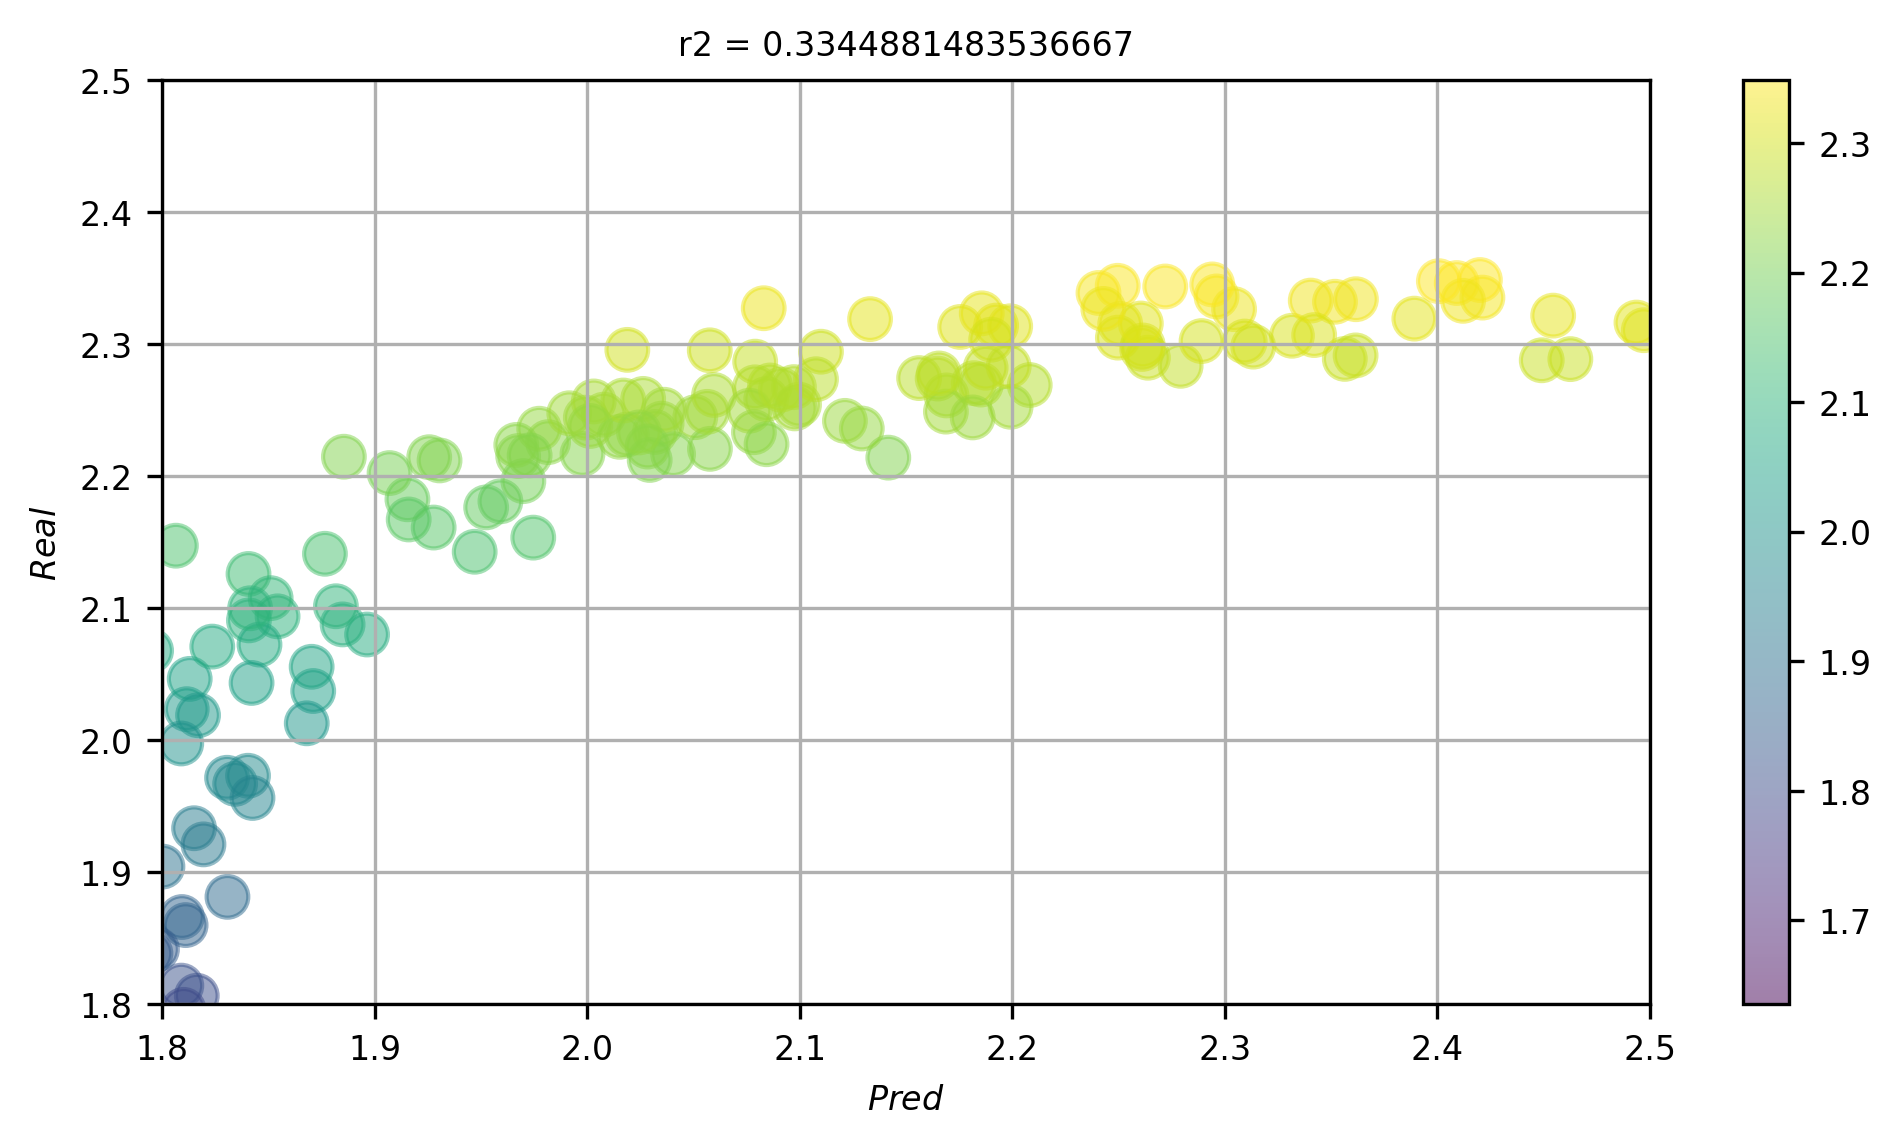

In [71]:

# Plot first and second principal component.

plt.figure(figsize=(8,4),dpi=300)

plt.scatter(pd.DataFrame(y_pred_aux),pd.DataFrame(y_test.values),
            c=y_test, cmap='viridis', alpha=0.5, s=100)
plt.title('r2 = {}'.format(r2_score(y_test, y_pred_aux)))
plt.colorbar()
plt.ylabel(r'$Real$')
plt.xlabel(r'$Pred$')
plt.xlim(1.8,2.5)
plt.ylim(1.8,2.5)
plt.grid()

plt.show()

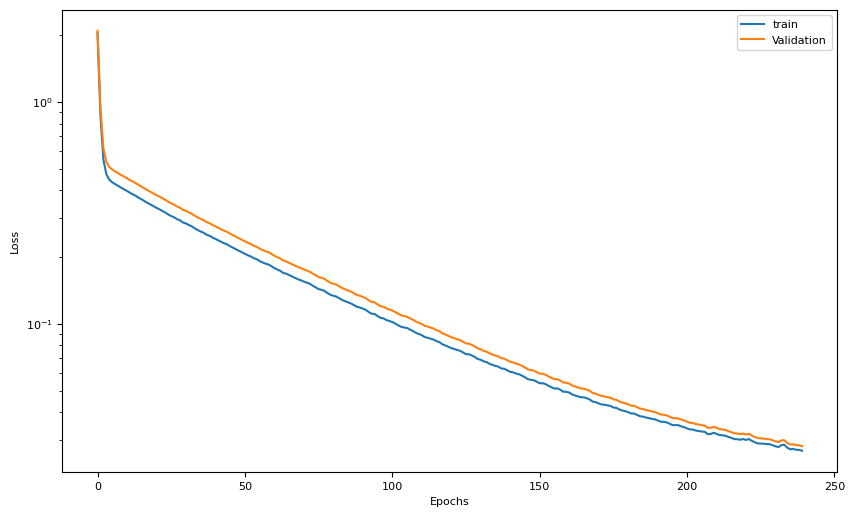

In [85]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
#ax.set_xscale('log')
ax.set_yscale('log')

#plt.xlim(80,100)
ax.legend()
plt.show()

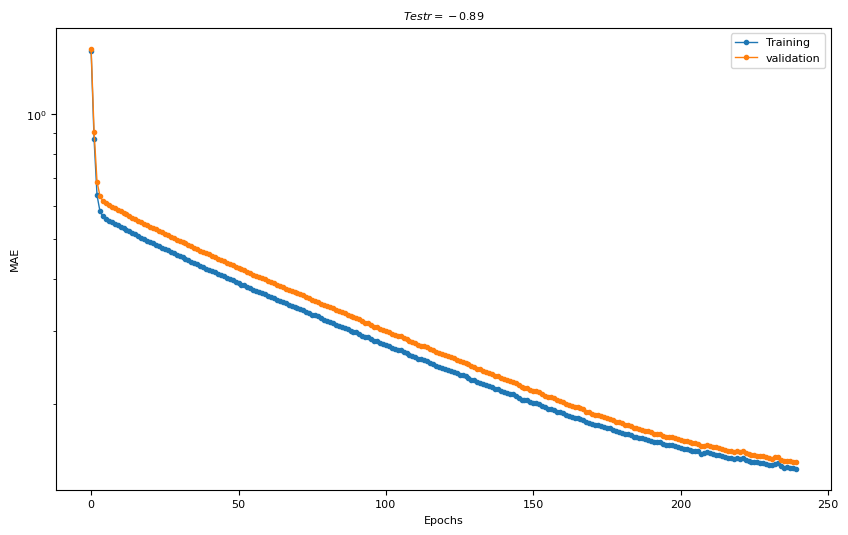

In [86]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['mae_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['mae_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('MAE')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['mae_test'])), metrics['mae_test'])[0][1]))
ax.legend()
ax.set_yscale('log')

#plt.ylim(0,3)
plt.show()

## Testing on experimental data

In [96]:
phenotypic = pd.read_csv('/Users/rodrigo/Post-Grad/BHRC/phenotypic.csv')
phenotypic = phenotypic.set_index('subject')

df = pd.read_csv('/Users/rodrigo/Post-Grad/BHRC/corr_matrices.csv')
df = df.set_index('subject')

outliers = np.loadtxt('/Users/rodrigo/Post-Grad/BHRC/subjects_outliers.txt').astype(int)
df = df.drop(df.loc[outliers,:].index)

df = df.drop(df.loc[[10019, 10081, 10095, 10132, 10143, 10242, 10758, 20158, 20494, 20608],:].index) # WHY ?
phenotypic = phenotypic.loc[df.index, :]

df.iloc[:,:-1] = np.tanh(df.iloc[:,:-1])
df = df[df.iloc[:,1:-1].max(axis=1) > .3]

df = np.tanh(df)

df['age_mri_baseline'] = phenotypic['age_mri_baseline']/12#/phenotypic['TOTAL_DAWBA'].max()


In [97]:
df = df.reset_index()
X_fmri = pd.DataFrame(df.drop(columns=['age_mri_baseline','subject']).values)
y =  pd.DataFrame((df['age_mri_baseline'].drop(columns=['age_mri_baseline','subject'])))

In [98]:
A = reconstruct_symmetric_matrix(333, X_fmri.iloc[:,:].mean(axis=0))

In [99]:
train_data, val_data = create_graph(X_fmri, X_fmri, y, y, size=333,method={'knn_group' : compute_KNN_graph(A, 10)})#, method={'threshold': 0.8})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

In [100]:
y_pred_aux_age = []
for y_i in val_loader:
    y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0]) 


#### Age decrease complexity https://www.frontiersin.org/articles/10.3389/fnins.2020.00700/full

In [102]:
my_dict_age = {}
for i in range(len(y.values)):
    my_dict_age[y.values[i][0]] = y_pred_aux_age[i]

In [103]:
y = pd.DataFrame(y)
y['y_pred'] = y_pred_aux_age
y = y.dropna()

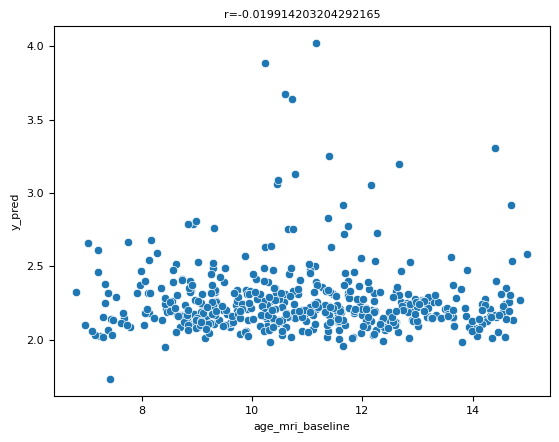

In [104]:
#sns.boxplot(y_test, x='Age', y='y_pred')

#sns.scatterplot(y, x='Max Motion (mm)', y='y_pred') 
#plt.title('r={}'.format(np.corrcoef([y['Max Motion (mm)'].values, y['y_pred'].values])[0,1]))
#plt.title('r={}'.format(r2_score(y_test['Max Motion (mm)'].values, y_test['y_pred'].values)))

sns.scatterplot(y, x='age_mri_baseline', y='y_pred') 
plt.title('r={}'.format(np.corrcoef([y['age_mri_baseline'].values, y['y_pred'].values])[0,1]))
#plt.title('r={}'.format(r2_score(y_test['Age'].values, y_test['y_pred'].values)))

plt.show()

In [86]:
results = merged_df[['Institution','Subject', 'Run']]
results['Age'] = y_pred_aux_age

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_19912/591760499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Age'] = y_pred_aux_age


In [87]:
results.to_csv('DX_012.csv')

### DX

In [ ]:
df_aux = df[df['DX'] == 0]


# Labels
y = (df_aux.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X_fmri = np.tanh(df_aux.iloc[:,:-2])

from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95,
                                                    shuffle=True, random_state=42)

train_data, val_data = create_graph(X_train, X_test, y_train, y_test) #,method={'threshold': 0.2})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

y_pred_aux_0 = []
for y_i in val_loader:
    y_pred_aux_0.append((model(y_i))[1].detach().numpy().ravel()[0]) 


In [ ]:
df_aux = df[df['DX'] == 1]


# Labels
y = (df_aux.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X_fmri = np.tanh(df_aux.iloc[:,:-2])

from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95,
                                                    shuffle=True, random_state=42)

train_data, val_data = create_graph(X_train, X_test, y_train, y_test) #,method={'threshold': 0.2})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

y_pred_aux_1 = []
for y_i in val_loader:
    y_pred_aux_1.append((model(y_i))[1].detach().numpy().ravel()[0]) 


In [ ]:
my_dict = {'1': y_pred_aux_1, '0' : y_pred_aux_0}


In [ ]:
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
#plt.ylim(1.8,2.1)
plt.show()

In [ ]:
X.shape

In [190]:
np.savetxt('Ising_GNN.txt', X.reshape(1200*17955))